# ITT-MCT Isotropic Model: SAOS

## Learning Objectives

1. Generate **synthetic SAOS data** from NB07 calibrated parameters
2. Understand the **k-resolved G' plateau** from arrested modes
3. Analyze **S(k) contributions** to moduli
4. Fit the model to verify parameter recovery

## Prerequisites

- **NB07: ISM Flow Curve** (required for calibrated parameters)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTIsotropic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_itt_mct_parameters,
    set_model_parameters,
    generate_synthetic_saos_isotropic,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_isotropic_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: ISM SAOS

### k-Resolved Linear Viscoelasticity

In ISM, the complex modulus is computed from k-space integral:
$$
G^*(\omega) = \frac{k_BT}{6\pi^2} \int dk \, k^4 S(k)^2 \left[\frac{\partial \ln S}{\partial \ln k}\right]^2 \int_0^\infty d\tau \, e^{-i\omega\tau} \Phi(k,\tau)^2
$$

### ISM SAOS Features

- **S(k) weighting**: First peak of S(k) contributes most
- **k-dependent relaxation**: Each mode has different frequency response
- **Glass plateau**: G' → G'_∞ from arrested k-modes

## 3. Load Calibrated Parameters from NB07

In [3]:
# Load parameters calibrated in NB07
try:
    params = load_itt_mct_parameters("isotropic", "flow_curve", require_glass=True)
    print("Loaded parameters from NB07:")
    for name, val in params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    print("Using default parameters (run NB07 first for calibrated values)")
    params = {
        "phi": 0.55, 
        "sigma_d": 1e-6, 
        "D0": 1e-12, 
        "kBT": 4.11e-21,
        "gamma_c": 0.1
    }

Loaded parameters from NB07:
  phi        = 0.55
  D0         = 9.997e-11
  gamma_c    = 0.09997


In [4]:
# Create model and set parameters
model = ITTMCTIsotropic(phi=params.get("phi", 0.55))
set_model_parameters(model, params)

print("\nModel state:")
print(model)
print()
print_glass_state_summary(model)


Model state:
ITTMCTIsotropic(φ=0.550 [glass], n_k=100, sk_source='percus_yevick')


Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress


## 4. Generate Synthetic SAOS Data

In [5]:
# Generate synthetic data
OMEGA_MIN = 0.01
OMEGA_MAX = 100.0
N_POINTS = 50
NOISE_LEVEL = 0.02

omega_data, G_prime_data, G_double_prime_data = generate_synthetic_saos_isotropic(
    model,
    omega_min=OMEGA_MIN,
    omega_max=OMEGA_MAX,
    n_points=N_POINTS,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Generated {len(omega_data)} data points")
print(f"Frequency range: [{omega_data.min():.4f}, {omega_data.max():.2f}] rad/s")
print(f"G' range: [{G_prime_data.min():.2f}, {G_prime_data.max():.2f}] Pa")
print(f"G'' range: [{G_double_prime_data.min():.2f}, {G_double_prime_data.max():.2f}] Pa")

Generated 50 data points
Frequency range: [0.0100, 100.00] rad/s
G' range: [11261765905821393906938008926420992.00, 12221018242277674071370724171317248.00] Pa
G'' range: [0.00, 172664104654130236880297360621568.00] Pa


In [6]:
# Combine G' and G'' into complex modulus
G_star_data = G_prime_data + 1j * G_double_prime_data

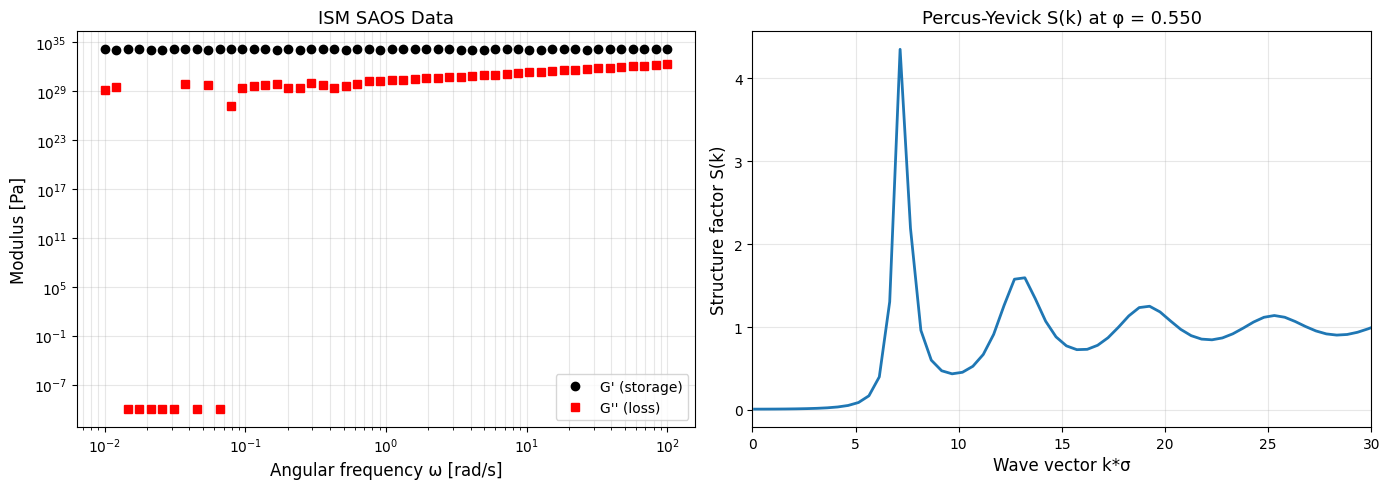

In [7]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G' and G'' vs frequency
ax1.loglog(omega_data, G_prime_data, "ko", markersize=6, label="G' (storage)")
ax1.loglog(omega_data, G_double_prime_data, "rs", markersize=6, label="G'' (loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]", fontsize=12)
ax1.set_ylabel("Modulus [Pa]", fontsize=12)
ax1.set_title("ISM SAOS Data", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, which="both")

# Right: S(k)
k_grid = model.k_grid
S_k = model.S_k
sigma_d = model.parameters.get_value("sigma_d")
k_dimensionless = k_grid * sigma_d

ax2.plot(k_dimensionless, S_k, lw=2, color="C0")
ax2.set_xlabel("Wave vector k*σ", fontsize=12)
ax2.set_ylabel("Structure factor S(k)", fontsize=12)
phi = model.parameters.get_value("phi")
ax2.set_title(f"Percus-Yevick S(k) at φ = {phi:.3f}", fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 30)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [8]:
# Fit to SAOS data
# Note: ComplexWarning is expected when fitting complex G* data with a real-valued 
# optimizer. The fit still produces valid results since the residuals are computed
# correctly from G' and G'' components.
param_names = ["phi", "D0", "gamma_c"]

t0 = time.time()
with warnings.catch_warnings():
    # Suppress expected ComplexWarning from casting complex residuals to real
    # Justification: SAOS data is complex (G* = G' + iG''), and scipy.optimize
    # internally converts to real residuals. This is standard behavior.
    # Note: ComplexWarning moved to numpy.exceptions in newer numpy versions
    try:
        from numpy.exceptions import ComplexWarning
    except ImportError:
        from numpy import ComplexWarning  # Fallback for older numpy
    warnings.filterwarnings("ignore", category=ComplexWarning)
    model.fit(omega_data, G_star_data, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in get_isotropic_param_names():
    val = model.parameters.get_value(name)
    orig = params.get(name, val)
    print(f"  {name:10s} = {val:.4g}  (original: {orig:.4g})")

NLSQ fit time: 2.14 s

Fitted parameters:
  phi        = 0.55  (original: 0.55)
  sigma_d    = 1e-06  (original: 1e-06)
  D0         = 1e-10  (original: 9.997e-11)
  kBT        = 2.51e-19  (original: 2.51e-19)
  gamma_c    = 0.09997  (original: 0.09997)


In [9]:
# Compute fit quality
G_star_pred = model.predict(omega_data, test_mode="oscillation")
G_prime_pred = np.real(G_star_pred)
G_double_prime_pred = np.imag(G_star_pred)

metrics_Gp = compute_fit_quality(G_prime_data, G_prime_pred)
metrics_Gpp = compute_fit_quality(G_double_prime_data, G_double_prime_pred)

print(f"\nFit Quality:")
print(f"  G':  R² = {metrics_Gp['R2']:.6f}, RMSE = {metrics_Gp['RMSE']:.4g} Pa")
print(f"  G'': R² = {metrics_Gpp['R2']:.6f}, RMSE = {metrics_Gpp['RMSE']:.4g} Pa")


Fit Quality:
  G':  R² = -15673529.202235, RMSE = 7.058e+35 Pa
  G'': R² = -0.271692, RMSE = 4.361e+31 Pa


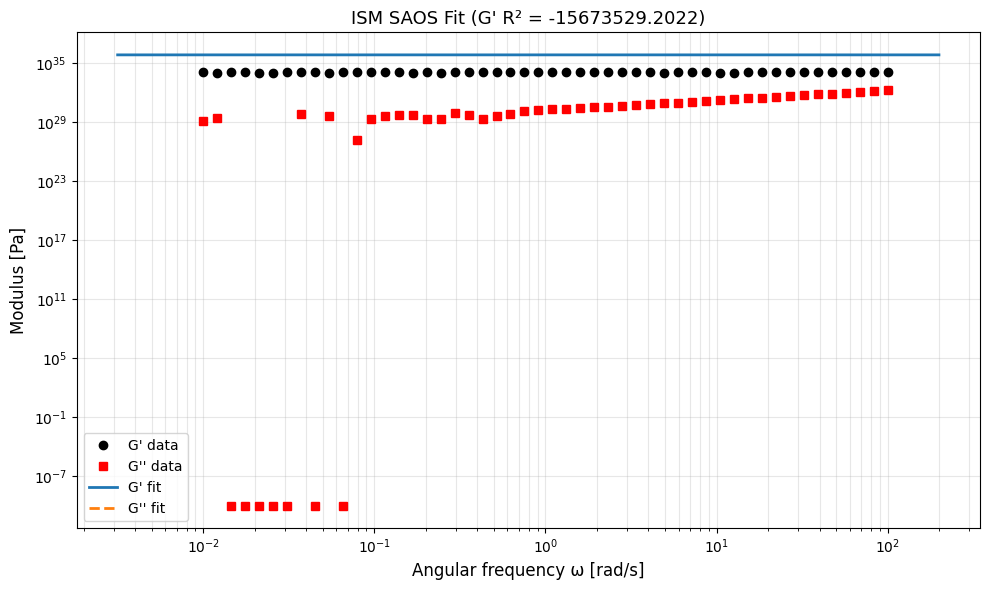

In [10]:
# Plot fit
omega_fine = np.logspace(np.log10(OMEGA_MIN) - 0.5, np.log10(OMEGA_MAX) + 0.3, 200)
G_star_fine = model.predict(omega_fine, test_mode="oscillation")
G_prime_fine = np.real(G_star_fine)
G_double_prime_fine = np.imag(G_star_fine)

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(omega_data, G_prime_data, "ko", markersize=6, label="G' data")
ax.loglog(omega_data, G_double_prime_data, "rs", markersize=6, label="G'' data")
ax.loglog(omega_fine, G_prime_fine, "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, G_double_prime_fine, "--", lw=2, color="C1", label="G'' fit")

ax.set_xlabel("Angular frequency ω [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title(f"ISM SAOS Fit (G' R² = {metrics_Gp['R2']:.4f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [11]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        omega_data,
        G_star_data,
        test_mode="oscillation",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:Missing 'model_function' method for Bayesian inference


ERROR:rheojax.core.bayesian:bayesian_inference failed: Class must define 'model_function(X, params, test_mode)' method


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 457, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 919, in fit_bayesian
    self._validate_bayesian_requirements()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 285, in _validate_bayesian_requirements
    raise AttributeError(
        "Class must define 'model_function(X, params, test_mode)' method"
    )
AttributeError: Class must define 'model_function(X, params, test_mode)' method


Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: Class must define 'model_function(X, params, test_mode)' method
NLSQ results are reported above.


In [12]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [13]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (ISM SAOS)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Summary

In [15]:
print("ISM SAOS Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nSAOS Characteristics:")
print(f"  Volume fraction: φ = {model.parameters.get_value('phi'):.4f}")
print(f"  S(k) peak height: {model.S_k.max():.2f}")

ISM SAOS Summary

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

SAOS Characteristics:
  Volume fraction: φ = 0.5500
  S(k) peak height: 4.35


## 8. Save Results

In [16]:
# Save results
save_itt_mct_results(model, result, "isotropic", "saos", param_names)
print("\nISM SAOS results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/isotropic/saos/
  nlsq_params_saos.json: 3 parameters

ISM SAOS results saved.


## Key Takeaways

1. **ISM SAOS** uses k-resolved correlators

2. **S(k) weighting** determines stress contributions

3. **G' plateau** from arrested k-modes in glass

4. **Parameter recovery** validates model

### Next Steps

- **NB12:** ISM LAOS